## Obtain the matrix representation of a relation from generating function

In [1]:
import sys

range = xrange if sys.version_info < (3,) else range

import numpy as np

def relation(items, cmp=lambda x, y: x < y, dtype='?'):
    """Return a two-dimensional boolean array of items cmp-relation."""
    shape = 2 * (len(items),)
    values = (cmp(x, y) for x in items for y in items)
    return np.fromiter(values, dtype=dtype).reshape(shape)

x = range(10)
r = relation(x)
print(r.astype(int))

[[0 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]]


## Plot a logical matrix with matplotlib

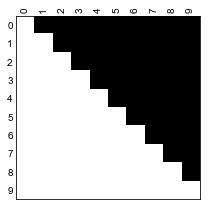

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

def lmatrix(m, labels, figsize=(3, 3), fontsize=10, family='Arial'):
    """Plot the square boolean array m with the given labels."""
    n = len(labels)
    assert m.shape == (n, n)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(m, cmap='Greys', interpolation='none')
    ticks = np.arange(n); ax.set_xticks(ticks); ax.set_yticks(ticks)
    ax.xaxis.tick_top()
    ax.set_xticklabels(labels, rotation=90, family=family)
    ax.set_yticklabels(labels, family=family)
    ax.tick_params(length=0, labelsize=fontsize)
    fig.tight_layout()

lmatrix(r, x)

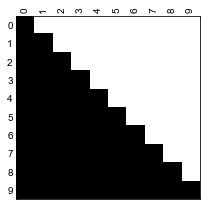

In [3]:
lmatrix(relation(range(10), lambda x, y: x >= y), range(10))

## Transitive closure (Floyd–Warshall)

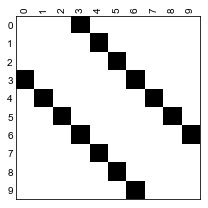

In [4]:
r = relation(range(10), lambda x, y: abs(x - y) == 3)
lmatrix(r, range(10))

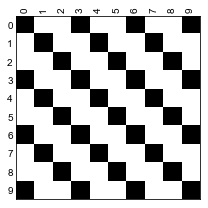

In [5]:
def transitive_closure(m, inplace=False):
    if not inplace:
        m = m.copy()
    for k in range(m.shape[0]):
        m |= m[None, k, :] & m[:, k, None]
    return m

lmatrix(transitive_closure(r), range(10))

## Convenience function, sort orders, identity matrix

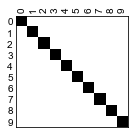

In [6]:
def relmatrix(items, cmp, labels=None, figsize=None, itemsize=0.2, sort=False, close=False, **kwargs):
    r = relation(items, cmp)
    if labels is None:
        labels = ['%s' % i for i in items]
    if figsize is None:
        figsize = 2 * (itemsize * len(items),)
    if close:
        transitive_closure(r, inplace=True)
    if sort:
        if sort in (True, 'colex'):
            order = np.lexsort(r.T)
        elif sort == 'lex':
            order = np.lexsort(np.flipud(~r))
        elif sort in ('short', 'shortcolex'):
            order = np.lexsort(np.row_stack((r.T, r.sum(1))))
        elif sort == 'shortlex':
            order = np.lexsort(np.row_stack((np.flipud(~r.T), r.sum(1))))
        else:
            raise NotImplementedError
        r = r[order][:, order]
        labels = np.take(labels, order)
    lmatrix(r, labels, figsize=figsize, **kwargs)

relmatrix(range(10), lambda x, y: x == y)

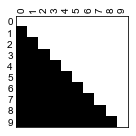

In [7]:
relmatrix(range(10), lambda x, y: x - y == 1, close=True)

## Plot bitwise operations

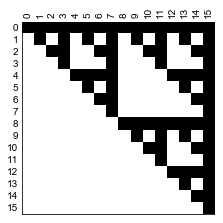

In [8]:
relmatrix(range(16), lambda x, y: x & y == x)

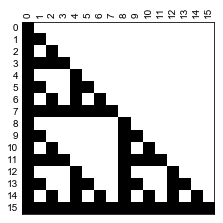

In [9]:
relmatrix(range(16), lambda x, y: x & y == y)

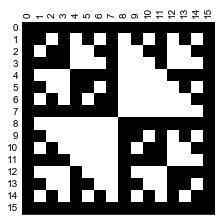

In [10]:
relmatrix(range(16), lambda x, y: x & y in (x, y))

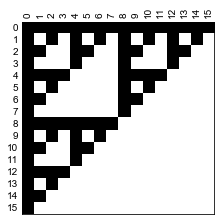

In [11]:
relmatrix(range(16), lambda x, y: not x & y)

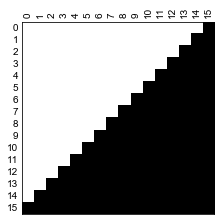

In [12]:
relmatrix(range(16), lambda x, y: x + y >= 15)

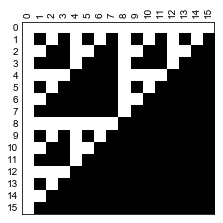

In [13]:
relmatrix(range(16), lambda x, y: x & y)

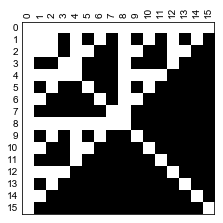

In [14]:
relmatrix(range(16), lambda x, y: x & y and x ^ y)

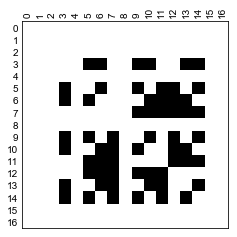

In [15]:
relmatrix(range(17), lambda x, y: x & y and x & y not in (x, y))

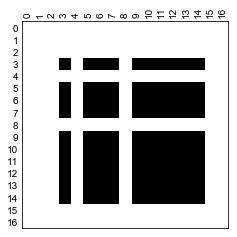

In [16]:
relmatrix(range(17), lambda x, y: x & y and x & y not in (x, y), close=True)

## Divisibility and primes

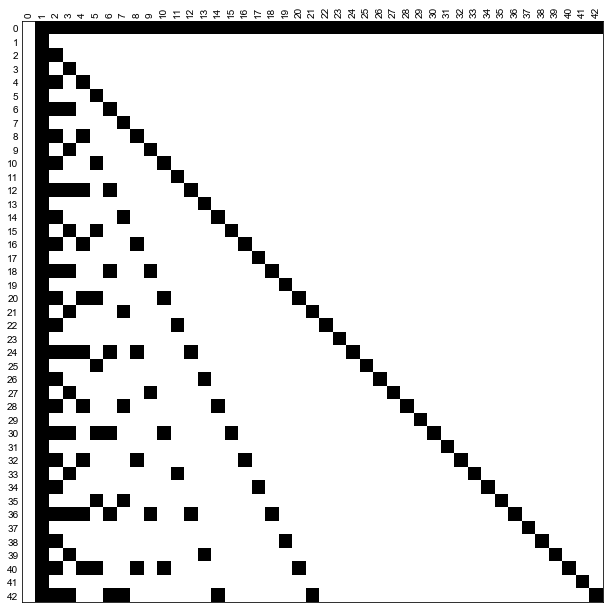

In [17]:
relmatrix(range(43), lambda x, y: y != 0 and not x % y)

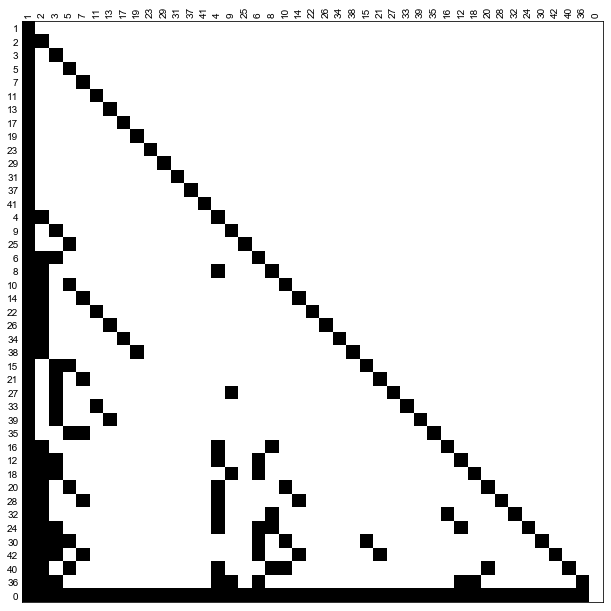

In [18]:
relmatrix(range(43), lambda x, y: y != 0 and not x % y, sort='shortlex')

## Python abstract base classes for containers

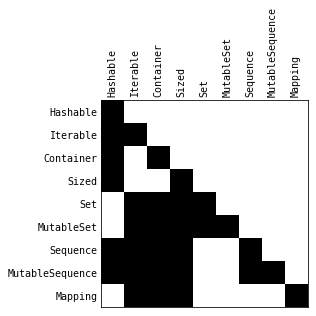

In [19]:
import collections

abcs = [
    'Hashable', 'Iterable', 'Container', 'Sized', 
    'Set', 'MutableSet', 'Sequence', 'MutableSequence',
    'Mapping',
]

types = [getattr(collections, n) for n in abcs]

relmatrix(types, lambda x, y: issubclass(x, y), labels=abcs, itemsize=.5, family='monospace')

## Python exception hierarchy

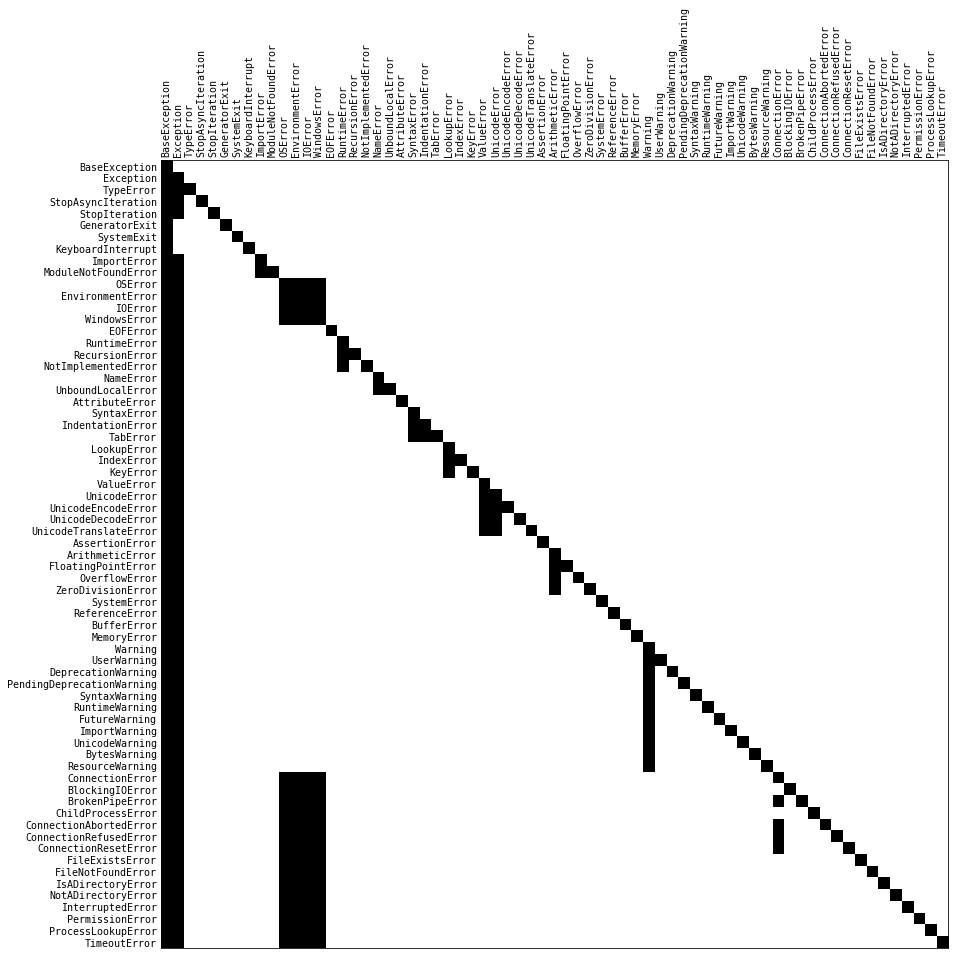

In [20]:
if sys.version_info < (3,):
    import exceptions

    enames = [n for n in dir(exceptions) if not n.startswith('_')]
    etypes = [getattr(exceptions, n)  for n in enames]
else:
    enames = [n for n, o in __builtins__.__dict__.items()
              if type(o) is type and issubclass(o, BaseException)]
    etypes = [getattr(__builtins__, n) for n in enames]
    
relmatrix(etypes, lambda x, y: issubclass(x, y), labels=enames, family='monospace', sort=True)

## More integer relations

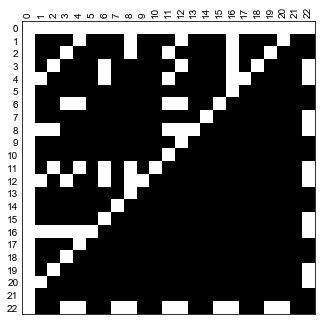

In [21]:
relmatrix(range(23), lambda x, y: x * 3 & y * 3)

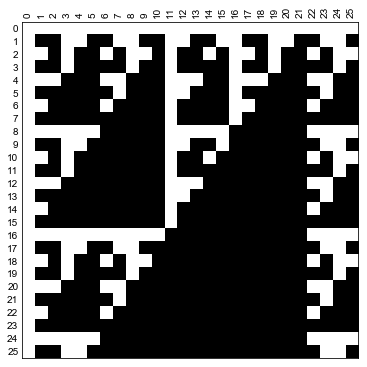

In [22]:
relmatrix(range(26), lambda x, y: x * 2 & y * 3)

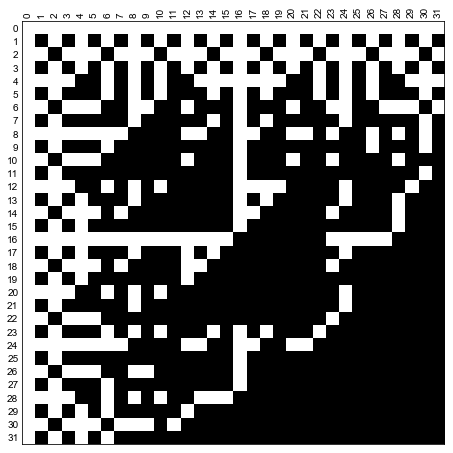

In [23]:
relmatrix(range(32), lambda x, y: x**2 & y**2)

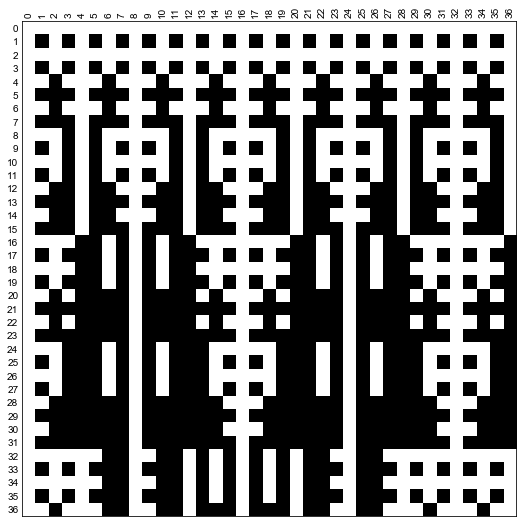

In [24]:
relmatrix(range(37), lambda x, y: x & y**2)

## Python keywords

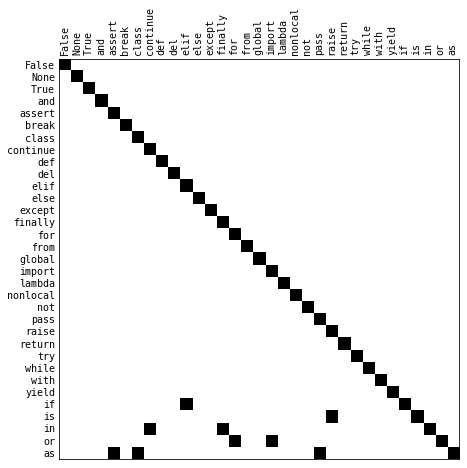

In [25]:
import keyword

relmatrix(keyword.kwlist, lambda x, y: x in y, family='monospace', sort='short')

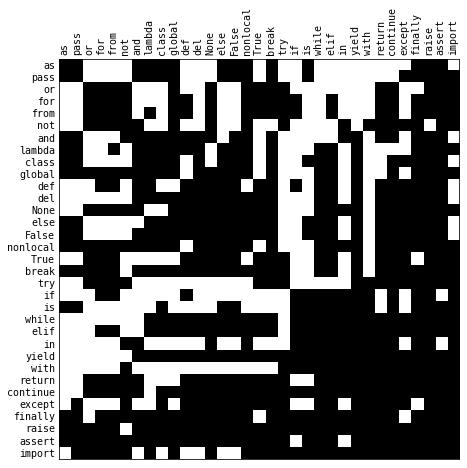

In [26]:
relmatrix(keyword.kwlist, lambda x, y: not set(x).isdisjoint(set(y)), family='monospace', sort=True)

## More subclass relations

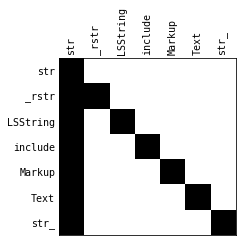

In [27]:
def itersubclasses(cls, proper=False, exclude=(type,)):
    queue = collections.deque(cls.__subclasses__() if proper else [cls])
    seen = set(exclude)
    while queue:
        cls = queue.popleft()
        if cls not in seen:
            seen.add(cls)
            yield cls
            queue.extend(cls.__subclasses__())

classes = list(itersubclasses(basestring if sys.version_info < (3,) else str))
cnames = [c.__name__ for c in classes]

relmatrix(classes, lambda x, y: issubclass(x, y), labels=cnames, itemsize=.5, family='monospace')

## Powersets

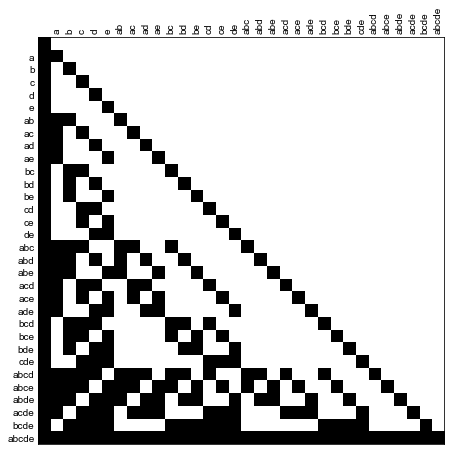

In [28]:
import itertools

def powerset(items):
    items = list(items)
    return itertools.chain.from_iterable(itertools.combinations(items, r)
        for r in range(len(items) + 1))

combos = [set(p) for p in powerset('abcde')]
clabels = [''.join(sorted(c)) for c in combos]

relmatrix(combos, lambda x, y: x >= y, labels=clabels)